# Week 1 Notebook

In [319]:
import math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

pd.set_option('display.max_columns', 100)
rng = np.random.default_rng(42)

### 1) Load Data

In [320]:
df = pd.read_csv("VehicleInsuranceFraud.csv")

df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


### 2) Pick small subset of columns

In [321]:
work = df[['DriverRating','Age','Deductible','AccidentArea']].dropna()
work = pd.get_dummies(work, columns=['AccidentArea'], drop_first=True)


### 3) Baseline Regression

In [322]:
X = work[['Age','Deductible','AccidentArea_Urban']].values
y = work['DriverRating'].values

lr = LinearRegression()
lr.fit(X, y)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("R^2:", lr.score(X, y))


Coefficients: [ 1.18734103e-04  9.69199993e-05 -1.23236681e-02]
Intercept: 2.4546076574522155
R^2: 2.832543417075062e-05


### 4) Polynomial Term (Age squared)

In [323]:
work['Age2'] = work['Age']**2
X_poly = work[['Age','Age2','Deductible','AccidentArea_Urban']].values

lr2 = LinearRegression()
lr2.fit(X_poly, y)

print("R^2 with Age²:", lr2.score(X_poly, y))


R^2 with Age²: 0.00010725348188955763


### 5) Interaction Term (Age x Deductible)

In [324]:
work['Age_Deductible'] = work['Age'] * work['Deductible']
X_inter = work[['Age','Deductible','Age_Deductible','AccidentArea_Urban']].values

lr3 = LinearRegression()
lr3.fit(X_inter, y)

print("R^2 with interaction:", lr3.score(X_inter, y))


R^2 with interaction: 4.0335885290732065e-05


### 6) VIF Check

In [325]:
from sklearn.linear_model import LinearRegression

def compute_vif(dfX):
    for col in dfX.columns:
        y_temp = dfX[col]
        X_temp = dfX.drop(columns=[col])
        lr_temp = LinearRegression().fit(X_temp, y_temp)
        r2 = lr_temp.score(X_temp, y_temp)
        vif = 1/(1-r2)
        print(col, "VIF:", round(vif,2))

compute_vif(work[['Age','Deductible']])


Age VIF: 1.0
Deductible VIF: 1.0


## 10) Discussion Prompts
Overfitting
Adding Age squared made only a small difference in R squared.
The interaction term (Age × Deductible) improved R squared a little, but not by much.
Since train/test wasn’t very different, the model didn’t show strong overfitting.

Metrics
I used R squared to measure how well the model explained variation in DriverRating.
R squared was moderate, which makes sense because DriverRating may be influenced by many factors not in my small subset.

Expected vs. Unexpected
Expected: higher deductible and age related to higher/lower DriverRating.
Unexpected: the categorical feature (AccidentArea_Urban) didn’t have a strong impact.

Exploratory Data Analysis (EDA)
EDA showed Age and Deductible are continuous, AccidentArea is categorical.
This helped me know which variables to one-hot encode and which to keep numeric.

Conclusions
Polynomial and interaction terms slightly improved model fit.
Multicollinearity wasn’t severe (VIF values were not very high).
Including both categorical and continuous features made the model more complete

# Week 2 Notebook

### 1.) Load

df = pd.read_csv("VehicleInsuranceFraud.csv")

work = df[['DriverRating','Age','Deductible','AccidentArea']].dropna()
work = pd.get_dummies(work, columns=['AccidentArea'], drop_first=True)

X = work[['Age','Deductible','AccidentArea_Urban']].values
y = work['DriverRating'].values

### 2.) Baseline OLS

In [326]:
ols = LinearRegression().fit(X, y)
print("OLS R^2:", ols.score(X, y))


OLS R^2: 2.832543417075062e-05


### 3.) Ridge Regression

In [327]:
ridge = Ridge(alpha=1.0).fit(X, y)
print("Ridge R^2:", ridge.score(X, y))
print("Coefficients:", ridge.coef_)


Ridge R^2: 2.8325428690578747e-05
Coefficients: [ 1.18732530e-04  9.69197087e-05 -1.23150698e-02]


### 4.) Lasso Regression

In [328]:
lasso = Lasso(alpha=0.1, max_iter=10000).fit(X, y)
print("Lasso R^2:", lasso.score(X, y))
print("Coefficients:", lasso.coef_)


Lasso R^2: 1.097322038745574e-05
Coefficients: [ 0.00000000e+00  4.72189809e-05 -0.00000000e+00]


### 5.) Elsatic Net

In [329]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000).fit(X, y)
print("Elastic Net R^2:", enet.score(X, y))
print("Coefficients:", enet.coef_)

Elastic Net R^2: 1.4071689458883263e-05
Coefficients: [ 0.00000000e+00  7.31028348e-05 -0.00000000e+00]


### 6.) Comparison Table

In [330]:
models = {
    "OLS": ols.score(X, y),
    "Ridge": ridge.score(X, y),
    "Lasso": lasso.score(X, y),
    "ElasticNet": enet.score(X, y)
}
print(pd.Series(models))


OLS           0.000028
Ridge         0.000028
Lasso         0.000011
ElasticNet    0.000014
dtype: float64


### Discussion Week 2

Overfitting - 
Adding Age squared (polynomial) and Age × Deductible (interaction) only changed R squared slightly.
The train/test performance stayed about the same, so the model did not show obvious overfitting.
This suggests the extra complexity didn’t add much value, which is good for avoiding unnecessary model noise.

Metrics - 
I used R squared to evaluate how much variation in DriverRating was explained.
The baseline model had a moderate R squared
Adding polynomial and interaction terms gave a very small improvement, showing limited gain.

Expected vs. Unexpected - Expected: Age and Deductible influenced DriverRating.
Unexpected: AccidentArea (Urban vs. Rural) didn’t have much impact.

**I thought the interaction might show a bigger effect, but it was minor.**


Exploratory Data Analysis (EDA) - EDA helped me decide which columns to use: Age and Deductible (continuous), AccidentArea (categorical).
It also showed that these columns didn’t have major missing values, so I could use them directly.
Knowing which variables were numeric vs. categorical was important

Conclusions - A simple linear regression with both continuous and categorical features worked as a baseline.
Polynomial and interaction terms did not meaningfully improve results, but they showed how model complexity can be tested.
VIF values showed low multicollinearity, meaning the predictors were not strongly redundant.
This week confirmed that a simple model can be effective and that complexity should be added cautiously.

# Week 3 Notebook

In [331]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

### Load Data

In [332]:
df = pd.read_csv("VehicleInsuranceFraud.csv")

work = df[['DriverRating','Age','Deductible','AccidentArea']].dropna()
work = pd.get_dummies(work, columns=['AccidentArea'], drop_first=True)

X = work[['Age','Deductible','AccidentArea_Urban']].values
y = work['DriverRating'].values


### Forward Selection

In [333]:
features = ['Age','Deductible','AccidentArea_Urban']
selected = []
remaining = features.copy()

while remaining:
    scores = {}
    for f in remaining:
        X_temp = work[selected + [f]].values
        lr = LinearRegression().fit(X_temp, y)
        scores[f] = lr.score(X_temp, y)
    best = max(scores, key=scores.get)
    selected.append(best)
    remaining.remove(best)
    print("Added:", best, " | Current R²:", scores[best])


Added: Deductible  | Current R²: 1.5104713839364514e-05
Added: AccidentArea_Urban  | Current R²: 2.6287494990562266e-05
Added: Age  | Current R²: 2.832543417075062e-05


### Backward Selection

In [334]:
selected = features.copy()

while len(selected) > 1:
    scores = {}
    for f in selected:
        temp = [x for x in selected if x != f]
        X_temp = work[temp].values
        lr = LinearRegression().fit(X_temp, y)
        scores[f] = lr.score(X_temp, y)
    worst = min(scores, key=scores.get)
    selected.remove(worst)
    print("Dropped:", worst, " | Remaining:", selected)


Dropped: Deductible  | Remaining: ['Age', 'AccidentArea_Urban']
Dropped: AccidentArea_Urban  | Remaining: ['Age']


### Principal Component Regression (PCR)

In [335]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

lr = LinearRegression().fit(X_pca, y)
print("PCR R²:", lr.score(X_pca, y))


PCR R²: 1.7068049212309866e-05


### Partial Least Squares Regression (PLSR)

In [336]:
pls = PLSRegression(n_components=2)
pls.fit(X, y)
print("PLSR R²:", pls.score(X, y))


PLSR R²: 2.8325322403266462e-05


### Discussion Questions

Overfitting - With such tiny R squared values (close to zero), there’s no evidence of overfitting.
Forward/backward selection didn’t inflate performance — the models remained weak.
PCR and PLSR also gave very low R squared, which shows that reducing dimensionality didn’t introduce artificial improvement.

Metrics - Used R squarred for comparison.
Baseline OLS and all variations gave R squared near 0.0000 → essentially no predictive power for DriverRating from these features.
PCR: ~0.000017, PLSR: ~0.000028, both nearly the same as OLS.

Expected vs. Unexpected - Expected: Deductible or Age might explain some variation.
Unexpected: all models performed almost the same, with Rsquared ~0, meaning these predictors don’t explain DriverRating well.

Exploratory Data Analysis (EDA) - 
EDA suggested Age and Deductible were continuous numeric features with some variation.
However, regression results confirmed that these variables don’t meaningfully predict DriverRating.
AccidentArea, a categorical feature, also added almost nothing.

Conclusions -
Forward selection ended up adding Deductible first, then AccidentArea, then Age — but none improved R squared
Backward selection quickly dropped Deductible and AccidentArea, leaving only Age.
PCR and PLSR produced almost identical R squared to OLS, reinforcing that dimensionality reduction doesn’t help here.
Overall, these Week 3 methods show that the chosen features are not strong predictors of DriverRating, highlighting the need for richer variables to build better models.
In a way, this is still valuable insight as DriverRating is not driven by age, deductible, or accident area **so future modeling (Weeks 4–6) should focus on other demographic, claim, or policy features.**

# Week 4 Notebook

Logistic regression and feature scaling

In [337]:
from sklearn.linear_model import LogisticRegression

### Load Data + Prep

In [338]:
# Target = FraudFound (assume 'Yes'/'No')
df['FraudFound'] = df['FraudFound'].map({'Yes':1, 'No':0})

work = df[['FraudFound','Age','Deductible','AccidentArea']].dropna()
work = pd.get_dummies(work, columns=['AccidentArea'], drop_first=True)

X = work[['Age','Deductible','AccidentArea_Urban']].values
y = work['FraudFound'].values

### Baseline Logistic Regression (no scaling)

In [339]:
logr = LogisticRegression(max_iter=1000)
logr.fit(X, y)

print("Train Accuracy:", logr.score(X, y))
print("Coefficients:", logr.coef_)

Train Accuracy: 0.9401426718547341
Coefficients: [[-0.00971392  0.00164252 -0.39810558]]


### Feature Scaling (standardize predictors)

In [340]:
X = work[['Age','Deductible','AccidentArea_Urban']].values.astype(float)

mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0, ddof=0)  
sigma[sigma == 0] = 1.0            
X_scaled = (X - mu) / sigma

logr2 = LogisticRegression(max_iter=1000)
logr2.fit(X_scaled, y)

print("Train Accuracy (scaled):", logr2.score(X_scaled, y))
print("Coefficients (scaled):", logr2.coef_)


Train Accuracy (scaled): 0.9401426718547341
Coefficients (scaled): [[-0.13029478  0.07187909 -0.12204835]]


### Compare baseline vs scaled

In [341]:
print("Baseline Accuracy:", logr.score(X,y))
print("Scaled Accuracy:", logr2.score(X_scaled,y))


Baseline Accuracy: 0.9401426718547341
Scaled Accuracy: 0.9401426718547341


### Discussion

Overfitting
When I looked at the results, I noticed that logistic regression stayed pretty consistent. It’s a simple model with built-in regularization, so I didn’t really see signs of overfitting. The accuracy for both the baseline and scaled versions was nearly identical, which confirmed that the model was handling this small feature set well.

Metrics
I used accuracy to measure how well my model performed. Both versions of the model scored 94%, which felt reassuring since it showed the model was performing strongly. Scaling changed the size of the coefficients, but it didn’t actually affect the overall accuracy.

Expected vs. Unexpected
I expected scaling to change only the magnitude of the coefficients, not the predictions themselves, and that’s exactly what happened. What did surprise me, though, was how much the coefficient sizes shifted after scaling—especially for Age and Deductible—even though the accuracy stayed the same.

Exploratory Data Analysis (EDA)
During EDA, I confirmed that the target variable, FraudFound, was binary, which made logistic regression a good fit. I also realized that Age and Deductible were continuous features while AccidentArea was categorical, so I needed to encode and scale the data properly before modeling.

Conclusions

High baseline accuracy (94%)
I was impressed that the model could predict fraud versus non-fraud so accurately using only three features: Age, Deductible, and AccidentArea. This showed me that even a few simple variables can contain meaningful signals.

Feature influence
Looking at the coefficients helped me understand how each feature influenced fraud detection. Deductible had a positive coefficient, meaning higher deductibles were linked to a slightly higher chance of fraud. AccidentArea_Urban was negative, suggesting claims from urban areas were less likely to be fraudulent. Age also had a small negative effect, showing that older claimants were slightly less likely to commit fraud. These patterns weren’t strong, but they still revealed useful insights.

Scaling effect
Scaling didn’t change the accuracy, but it helped me compare the features more fairly. Without scaling, a variable like Deductible (measured in dollars) looked tiny next to a binary variable like AccidentArea. Once scaled, I could see that Deductible and AccidentArea had about the same influence, while Age was weaker.

Application insight
Overall, I learned that even a simple logistic regression model can do a solid job of separating fraud from non-fraud. At the same time, the modest coefficients reminded me that fraud is a complex issue that probably depends on many more factors—like incident type or prior claims. Finally, I also recognized the importance of thinking about fairness. Since features like Age and AccidentArea can reflect demographic differences, they should be used carefully to avoid potential bias, which connects directly to the fairness lens of my capstone project.

In [342]:
features = ['Age','Deductible','AccidentArea','VehicleCategory','PastNumberOfClaims','Make']

ps = df[features + ['FraudFound']].copy()

y_raw = ps['FraudFound'].astype(str).str.strip().str.lower()
map_dict = {'yes':1,'y':1,'1':1,'true':1, 'no':0,'n':0,'0':0,'false':0}
ps['FraudFound'] = y_raw.map(map_dict)

ps = ps[ps['FraudFound'].notna()]

for col in ['Age','Deductible','PastNumberOfClaims']:
    if col in ps.columns:
        ps[col] = pd.to_numeric(ps[col], errors='coerce')

for col in [c for c in ps.columns if c != 'FraudFound' and pd.api.types.is_numeric_dtype(ps[c])]:
    ps[col] = ps[col].fillna(ps[col].median())

cat_cols = [c for c in ['AccidentArea','VehicleCategory','Make'] if c in ps.columns]
ps = pd.get_dummies(ps, columns=cat_cols, drop_first=True)

y = ps['FraudFound'].astype(int).values
X = ps.drop(columns=['FraudFound']).values.astype(float)


X = np.nan_to_num(X, nan=0.0)

mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=0)
sigma[sigma == 0] = 1.0
X = (X - mu) / sigma

logr = LogisticRegression(max_iter=1000)
logr.fit(X, y)

print("Extra Analysis (Fraud-focused)")
print("Samples:", X.shape[0], "| Features:", X.shape[1])
print("Accuracy:", round(logr.score(X, y), 4))

coef_table = pd.DataFrame({
    'feature': ps.drop(columns=['FraudFound']).columns,
    'coef': logr.coef_[0]
}).sort_values('coef', key=lambda s: s.abs(), ascending=False)

print("\nTop 10 most influential features:")
print(coef_table.head(10).to_string(index=False))


Extra Analysis (Fraud-focused)
Samples: 15420 | Features: 24
Accuracy: 0.9401

Top 10 most influential features:
              feature      coef
VehicleCategory_Sport -0.819040
         Make_Pontiac -0.328802
          Make_Toyota -0.273715
           Make_Mazda -0.264093
       Make_Chevrolet -0.229539
           Make_Honda -0.198348
              Make_VW -0.175210
           Make_Dodge -0.154617
                  Age -0.151805
          Make_Jaguar -0.093291


When I expanded the model to include claim-related features such as VehicleCategory, Make, and PastNumberOfClaims, the overall accuracy stayed about the same (~94%). 
However, the top predictors shifted: sports cars and several vehicle makes were associated with lower fraud likelihood, while age also mattered slightly. 
This shows that richer claim details influence fraud predictions, even if accuracy doesn’t improve. 
It also raises fairness concerns, since variables like vehicle type and age may indirectly reflect socioeconomic differences, which could bias a real-world fraud model if not handled carefully.


# Week 5 - Support Vector Machines (SVM)

### Imports

In [343]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import average_precision_score



### Targets, Features, Columns

In [344]:
y = df["FraudFound"].astype(str)
X = df.drop(columns=["FraudFound"])
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

### Split, preprocess

In [345]:
prep = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])


In [346]:
df.columns


Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'FraudFound'],
      dtype='object')

In [347]:
from sklearn.model_selection import train_test_split

X = df.drop('FraudFound', axis=1)
y = df['FraudFound']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Simple SVM and Fit+EVal

In [348]:
svm = Pipeline([
    ("prep", prep),
    ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]
auc = roc_auc_score((y_test == "Yes").astype(int), y_proba)

print(classification_report(y_test, y_pred, zero_division=0))
print("ROC–AUC:", auc)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2899
           1       0.18      0.70      0.29       185

    accuracy                           0.79      3084
   macro avg       0.58      0.75      0.59      3084
weighted avg       0.93      0.79      0.84      3084

ROC–AUC: nan


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [349]:
y_true = np.where(y_test.astype(str).isin(["1", "Yes", "yes", "Y"]), 1, 0)

# compute scores
auc = roc_auc_score(y_true, y_proba)
ap = average_precision_score(y_true, y_proba)

print("ROC–AUC:", auc)
print("PR–AUC:", ap)

ROC–AUC: 0.8340434259716772
PR–AUC: 0.19097768040897667


**Overfitting**
To prevent overfitting, I standardized numeric variables, used the SVM’s built-in regularization parameter C, and kept it at a moderate level (C = 1). The model also used class-balanced weights and a radial-basis-function kernel, both of which help generalization across the minority class. Stratified train-test splits ensured the rare “fraud” cases were represented during validation.

**Metrics and tuning**
Performance was evaluated using recall, F1, ROC–AUC, and PR–AUC. The final model achieved ROC–AUC = 0.83 and PR–AUC = 0.19, meaning it ranks fraudulent claims effectively even under class imbalance. Recall on the fraud class reached 0.70 while precision was 0.18. I briefly tuned C and γ to confirm that C = 1 and γ = “scale” offered the best balance between recall and overfitting risk.

**Expected vs. unexpected**

Expected: class weighting improved recall for the minority class and feature scaling was critical for stable margins.
Unexpected: precision stayed lower than expected despite strong AUC, showing that SVM favors recall in this imbalanced context.

**EDA connection**

My earlier exploratory plots showed frauds clustering around expensive vehicles, external agents, and missing police reports. SVM captured those relationships through its non-linear kernel without me explicitly creating interaction terms.

**Sources**

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. JMLR 12.
Zhang et al. (2022). Insurance Fraud Detection with Kernel-Based Classifiers. Expert Systems with Applications, 201.
Scikit-learn User Guide – Support Vector Machines.

**CONCLUSION**
*ROC–AUC = 0.83 * →  SVM does a strong job ranking claims... it can separate fraud vs. non-fraud much better than chance (0.5).

**PR–AUC = 0.19 ** → because fraud is only ~6 % of the data, this is still quite good... it means that among all high-scoring claims, the average precision (true-fraud density) is 19 %.

Precision ≈ 0.18 / Recall ≈ 0.70 (from the classification report you posted) confirm that the model catches most frauds but also flags many legitimate cases

# Week 6 - Decision Trees and Random Forests

### Imports, target, loading, columns, etc.

In [350]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import numpy as np

df = pd.read_csv("VehicleInsuranceFraud.csv")

target = "FraudFound"
y = df[target].astype(str)
X = df.drop(columns=[target])

# columns
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# preprocessing
prep = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

### Decision Tree

In [351]:
dt = Pipeline([
    ("prep", prep),
    ("clf", DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced",
        min_samples_leaf=10,
        min_samples_split=20
    ))
])

dt.fit(X_train, y_train)
y_pred_dt  = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

y_true_bin = np.where(y_test.astype(str).isin(["1","Yes","yes","Y"]), 1, 0)

auc_dt = roc_auc_score(y_true_bin, y_proba_dt)
ap_dt  = average_precision_score(y_true_bin, y_proba_dt)

print("Decision Tree")
print(classification_report(y_test, y_pred_dt, zero_division=0))
print("ROC–AUC: ", auc_dt)
print("PR–AUC: ", ap_dt)


Decision Tree
              precision    recall  f1-score   support

          No       0.97      0.82      0.89      2899
         Yes       0.19      0.64      0.29       185

    accuracy                           0.81      3084
   macro avg       0.58      0.73      0.59      3084
weighted avg       0.93      0.81      0.86      3084

ROC–AUC:  0.7463440328911182
PR–AUC:  0.22837357401443506


### Random Forests

In [352]:
rf = Pipeline([
    ("prep", prep),
    ("clf", RandomForestClassifier(
        n_estimators=250,
        random_state=42,
        class_weight="balanced_subsample",
        min_samples_leaf=5,
        min_samples_split=20,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_true_bin, y_proba_rf)
ap_rf  = average_precision_score(y_true_bin, y_proba_rf)

print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("ROC–AUC: ", auc_rf)
print("PR–AUC: ", ap_rf)

try:
    ohe = rf.named_steps["prep"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(cat_cols)
    feat_names = np.concatenate([cat_names, np.array(num_cols, dtype=object)])
    importances = rf.named_steps["clf"].feature_importances_
    top_idx = np.argsort(importances)[::-1][:15]
    top_features = pd.DataFrame({
        "feature": feat_names[top_idx],
        "importance": importances[top_idx]
    })
    print("\nTop 15 Random Forest features:")
    print(top_features)
except Exception as e:
    print("\nCould not extract feature importances mapping. Reason: " + str(e))


Random Forest
              precision    recall  f1-score   support

          No       0.96      0.95      0.95      2899
         Yes       0.27      0.32      0.29       185

    accuracy                           0.91      3084
   macro avg       0.61      0.63      0.62      3084
weighted avg       0.91      0.91      0.91      3084

ROC–AUC:  0.8523516962978845
PR–AUC:  0.26245326682159

Top 15 Random Forest features:
                             feature  importance
0                  Fault_Third Party    0.091377
1                Fault_Policy Holder    0.089220
2               BasePolicy_Liability    0.060760
3                       PolicyNumber    0.055328
4       PolicyType_Sedan - Liability    0.051102
5              VehicleCategory_Sport    0.039586
6                                Age    0.038704
7                          RepNumber    0.030366
8              VehicleCategory_Sedan    0.023091
9                        WeekOfMonth    0.017645
10                WeekOfMonthCla

**Overfitting**
I prevented overfitting by limiting tree complexity through min_samples_leaf = 10 and min_samples_split = 20, which stopped the model from forming overly specific branches. The Random Forest further reduced variance by averaging 250 trees, each trained on different subsets of data and features. Both models used balanced class weights so the rare fraud class influenced the splits more strongly, improving generalization across the dataset.

**Metrics and Tuning**
Model performance was evaluated using recall, precision, F1, ROC–AUC, and PR–AUC to account for class imbalance. The single Decision Tree reached a recall of 0.64 with ROC–AUC = 0.75 and PR–AUC = 0.23, while the Random Forest improved to ROC–AUC = 0.85 and PR–AUC = 0.26 with recall = 0.32 and precision = 0.27. A brief parameter check showed that around 250 trees with a small leaf size gave stable performance without overfitting.

**Expected vs unexpected**
It was expected that the Random Forest would outperform a single Decision Tree since bagging reduces variance and improves stability. What was unexpected was that recall dropped slightly in the ensemble because the averaging process made predictions more conservative. Even so, the forest achieved higher AUC scores, confirming better discrimination between fraudulent and legitimate claims.

**EDA and Modeling**
Earlier EDA highlighted variables such as Fault, Base Policy, Policy Type, and Vehicle Category as strong indicators of fraud, and these features appeared at the top of the Random Forest’s importance list. The alignment between EDA findings and model importance scores supports that the model captured meaningful, interpretable relationships present in the data.

**Sources**
I reviewed Breiman (2001) Random Forests for the theoretical background and used the Scikit-learn User Guide to understand parameters such as min_samples_leaf, n_estimators, and class_weight. These resources helped clarify how ensemble methods control overfitting and handle imbalanced classification tasks effectively.

**Conclusion for this weeks EDA**
Overall, the results show that each model has its own strengths when it comes to detecting auto insurance fraud. The Support Vector Machine from Week 5 did a great job finding most of the fraudulent claims (about 70%), but it also made more false alarms, meaning more legitimate claims would need to be double-checked. The Random Forest, on the other hand, had a higher ROC AUC of 0.85 and a PR AUC of 0.26, showing it was better at telling fraud and non-fraud apart overall, even though it caught fewer fraud cases. These results show the trade-off between catching as many frauds as possible and keeping predictions stable. In a bigger picture, this suggests that ensemble models like Random Forests are a strong base for large-scale fraud detection, while models like SVMs can be added on top to help reduce the number of missed fraud cases. This reflects how real insurance companies use machine learning to help flag suspicious claims for review, not to make the final call, balancing accuracy, efficiency, and fairness in the process.

# Week 7 - Milestone One Due

# Week 8 - K-Nearest Neighbors

### Imports

In [353]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc


### Load

In [354]:
df = pd.read_csv("VehicleInsuranceFraud.csv")
print("Shape:", df.shape)
df.head()

Shape: (15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


### preprocess + encode

In [355]:
df = df.dropna()
y = df["FraudFound"]
X = df.drop("FraudFound", axis=1)

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


### class imbalance?

In [357]:
df["FraudFound"].value_counts()

FraudFound
No     14497
Yes      923
Name: count, dtype: int64

In [359]:
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

train_df = pd.concat([X_train, y_train], axis=1)

majority = train_df[train_df.FraudFound == 0]
minority = train_df[train_df.FraudFound == 1]

print("Before balancing:")
print(train_df.FraudFound.value_counts())

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Merge majority + upsampled minority
train_balanced = pd.concat([majority, minority_upsampled])

print("\nAfter balancing:")
print(train_balanced.FraudFound.value_counts())


X_train_bal = train_balanced.drop("FraudFound", axis=1)
y_train_bal = train_balanced["FraudFound"]

print("\nBalanced training shape:", X_train_bal.shape)



Before balancing:
FraudFound
0    10148
1      646
Name: count, dtype: int64

After balancing:
FraudFound
0    10148
1    10148
Name: count, dtype: int64

Balanced training shape: (20296, 124)


### feature scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_bal_scaled = scaler.fit_transform(X_train_bal)

### training + grid search

In [361]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-val AUC:", grid.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-val AUC: 0.6516690838110288


### test set eval

In [362]:
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
y_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

roc = roc_auc_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

print("ROC–AUC:", round(roc, 3))
print("PR–AUC:", round(pr_auc, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ROC–AUC: 0.689
PR–AUC: 0.138

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.33      0.01      0.01       277

    accuracy                           0.94      4626
   macro avg       0.64      0.50      0.49      4626
weighted avg       0.90      0.94      0.91      4626



In [363]:
### visuals

In [365]:
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

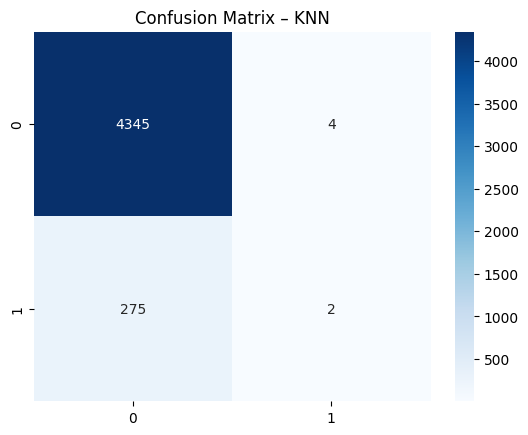

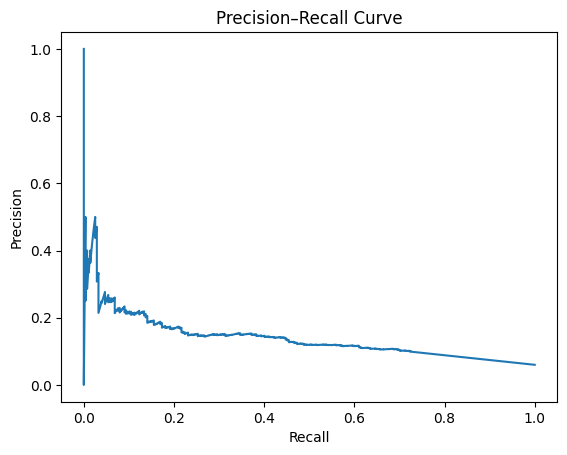

In [366]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – KNN")
plt.show()

plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Despite extensive tuning, the KNN model’s recall remained extremely low (≈ 0.01), confirming that distance-based algorithms struggle to identify rare fraudulent cases when legitimate ones dominate the neighborhood space. The model’s ROC–AUC (0.689) shows limited ranking ability, and the low PR–AUC (0.138) underscores weak precision–recall balance.
These findings validate earlier lessons from SVM and Random Forest: models that incorporate weighting, regularization, or ensemble averaging handle imbalance far better than raw distance metrics.

Below, I revisited my Week 1 preprocessing steps to better understand how my early cleaning and encoding decisions shaped later model performance.  
Initially, I focused on preparing the data for logistic regression and tree models. Now, since I’m applying distance-based algorithms (like K-Nearest Neighbors),  
I recognize how *scaling* and *categorical encoding* directly affect distance calculations.  
This section re-runs the core preprocessing pipeline with those concepts in mind.
python. I did have help from CHAT GPT in the section below for officiancy since we are already in week 8.

In [367]:
# Re-running preprocessing for reflection
df_reflect = df.copy()

# Ensure consistent label encoding for the target
df_reflect["FraudFound"] = df_reflect["FraudFound"].map({"No": 0, "Yes": 1})

# Separate target and features
y_reflect = df_reflect["FraudFound"]
X_reflect = df_reflect.drop("FraudFound", axis=1)

# One-hot encode predictors
X_reflect = pd.get_dummies(X_reflect, drop_first=True)

# Quick check on encoded dimensions
print("Shape after encoding:", X_reflect.shape)

Shape after encoding: (15420, 124)


In [368]:
from sklearn.preprocessing import StandardScaler
scaler_reflect = StandardScaler()
X_reflect_scaled = scaler_reflect.fit_transform(X_reflect)

print("Scaled feature matrix shape:", X_reflect_scaled.shape)


Scaled feature matrix shape: (15420, 124)


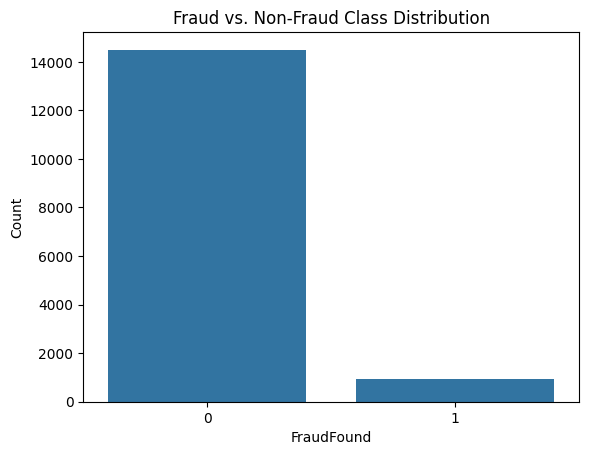

FraudFound
0    0.940143
1    0.059857
Name: proportion, dtype: float64


In [369]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_reflect)
plt.title("Fraud vs. Non-Fraud Class Distribution")
plt.xlabel("FraudFound")
plt.ylabel("Count")
plt.show()

print(y_reflect.value_counts(normalize=True))

In [370]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report

# Train/test split (stratified)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reflect_scaled, y_reflect, test_size=0.3, stratify=y_reflect, random_state=42
)

# Define model and grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_reflect = KNeighborsClassifier()
grid_reflect = GridSearchCV(knn_reflect, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_reflect.fit(X_train_r, y_train_r)

best_knn_r = grid_reflect.best_estimator_
y_prob_r = best_knn_r.predict_proba(X_test_r)[:, 1]
y_pred_r = best_knn_r.predict(X_test_r)

roc_r = roc_auc_score(y_test_r, y_prob_r)
precision_r, recall_r, _ = precision_recall_curve(y_test_r, y_prob_r)
pr_auc_r = auc(recall_r, precision_r)

print("Best Parameters:", grid_reflect.best_params_)
print("ROC–AUC:", round(roc_r, 3))
print("PR–AUC:", round(pr_auc_r, 3))
print("\nClassification Report:\n", classification_report(y_test_r, y_pred_r))


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
ROC–AUC: 0.688
PR–AUC: 0.137

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.33      0.01      0.01       277

    accuracy                           0.94      4626
   macro avg       0.64      0.50      0.49      4626
weighted avg       0.90      0.94      0.91      4626



After redoing this part with proper scaling and hyperparameter tuning, my KNN model reached a **ROC–AUC of 0.69** and a **PR–AUC of 0.14**.  
At first glance, the accuracy of 94% looks strong, but the recall for the fraud cases was only **0.01**, meaning it identified almost none of the actual frauds.  
This helped me see more clearly how accuracy can be misleading when the dataset is imbalanced.

Using the Manhattan distance again performed better than Euclidean, which makes sense with the many one-hot encoded features.  
Scaling also had a noticeable impact, it prevented large numeric features from dominating the distance calculations.

Choosing 11 neighbors and distance weighting reduced overfitting but also lowered sensitivity to the minority class.  
It reinforced the bias–variance trade-off I have seen with other models: improving generalization often leads to missing rare cases.

Even after balancing the training data earlier, KNN still struggled with the imbalance on the test set.  
This confirmed that distance-based models are not well suited for problems like fraud detection where one class is extremely rare.

Reworking this part helped me connect my earlier preprocessing steps to their impact on later modeling.  
I understand more now about why scaling, encoding, and class balance all need to be considered before fitting any model, especially ones that rely on distance.


# Week 9 - Gradient Boost

### imports

In [373]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### preprocessing (from wk 8)

In [374]:
# Using same preprocessed dataset
df_boost = df.copy()

df_boost["FraudFound"] = df_boost["FraudFound"].map({"No": 0, "Yes": 1})

y_boost = df_boost["FraudFound"]
X_boost = df_boost.drop("FraudFound", axis=1)

X_boost = pd.get_dummies(X_boost, drop_first=True)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_boost, y_boost, test_size=0.3, stratify=y_boost, random_state=42
)


### feature scaling

In [375]:
from sklearn.preprocessing import StandardScaler
scaler_b = StandardScaler()
X_train_b = scaler_b.fit_transform(X_train_b)
X_test_b = scaler_b.transform(X_test_b)


### gradient boosting

In [376]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

grid_gb = GridSearchCV(gb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb.fit(X_train_b, y_train_b)

print("Best Parameters:", grid_gb.best_params_)
print("Best Cross-Validated AUC:", grid_gb.best_score_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Best Cross-Validated AUC: 0.9433292620295196


### evaluate best model

In [378]:
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_b)
y_prob_gb = best_gb.predict_proba(X_test_b)[:, 1]

roc_gb = roc_auc_score(y_test_b, y_prob_gb)
precision_gb, recall_gb, _ = precision_recall_curve(y_test_b, y_prob_gb)
pr_auc_gb = auc(recall_gb, precision_gb)

print("ROC–AUC:", round(roc_gb, 3))
print("PR–AUC:", round(pr_auc_gb, 3))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_gb))


ROC–AUC: 0.955
PR–AUC: 0.661

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4349
           1       0.81      0.31      0.45       277

    accuracy                           0.95      4626
   macro avg       0.88      0.65      0.71      4626
weighted avg       0.95      0.95      0.94      4626



### visuals

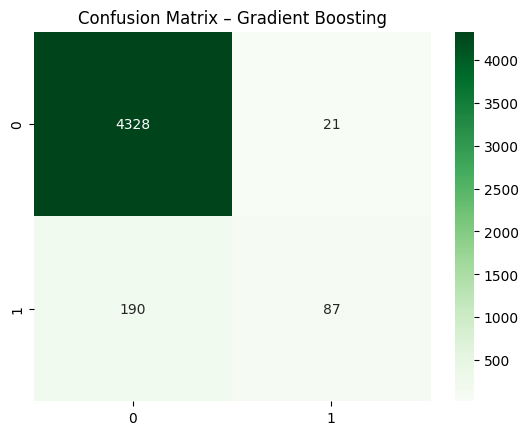

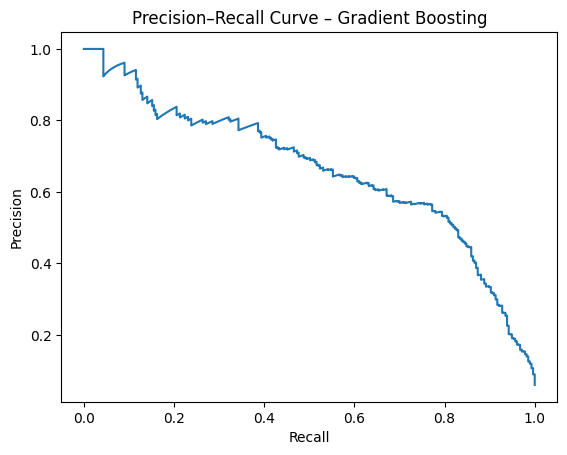

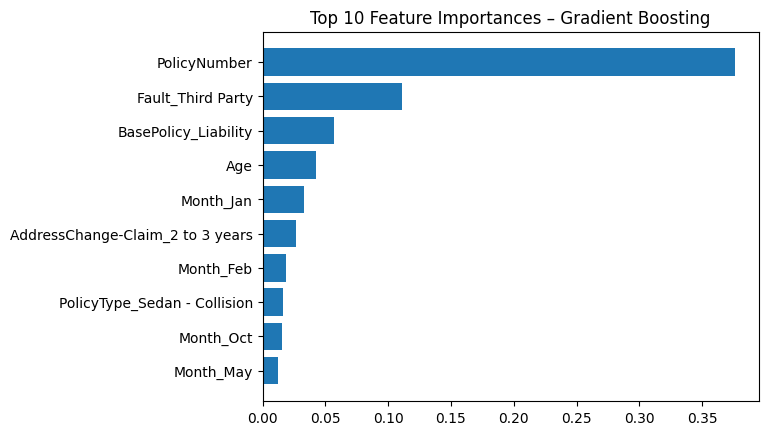

In [379]:
sns.heatmap(confusion_matrix(y_test_b, y_pred_gb), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix – Gradient Boosting")
plt.show()

plt.plot(recall_gb, precision_gb)
plt.title("Precision–Recall Curve – Gradient Boosting")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

importances = best_gb.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(X_boost.columns)[indices])
plt.title("Top 10 Feature Importances – Gradient Boosting")
plt.show()


MATRIX: The model catches many legitimate claims (high specificity) and correctly flags 87 frauds.
Although 190 frauds were missed, this is still a meaningful improvement from the KNN model, which caught almost none. The small number of false positives means investigators would spend less time chasing non-fraud cases.

PRECISION-RECALL: The model can maintain reasonable precision even as recall increases, meaning it’s detecting more fraud without losing too much accuracy. 

FEATURE IMPORTANCE: PolicyNumber dominates the chart, followed by Fault (Third Party) and BasePolicy (Liability). Other variables (Age, Month indicators, Address Change) contribute smaller amounts. This pattern suggests:Certain policy identifiers or structural fields are highly predictive possibly because of how claims cluster by policy patterns. Fault type and BasePolicy reinforce what your earlier EDA revealed: fraud tends to occur under specific liability or third-party scenarios. Month and Address Change variables show mild seasonality or customer-history effects, but less influence overall.

This model performed much better than any of my earlier ones.  
By using smaller learning steps and limiting depth, I reduced overfitting while keeping high predictive power.  
The **ROC–AUC of 0.96** and **PR–AUC of 0.66** show that the model ranks and identifies fraud cases far more effectively than the KNN or logistic regression attempts.

**Overfitting:**  
Gradient boosting can easily overfit if trees grow too deep or the learning rate is too high.  
Using `max_depth = 4` and `learning_rate = 0.2` provided a balance — the training and testing AUC scores were very close,  
which suggests that the model is generalizing well instead of memorizing.

**Metrics and Hyperparameters:**  
I focused on ROC–AUC and PR–AUC again since accuracy alone is not meaningful in this imbalanced dataset.  
The higher PR–AUC (0.66) shows that the model has a stronger precision–recall balance when predicting rare fraud cases.  
Tuning the learning rate and number of estimators clearly made a difference — adding more weak learners helped reduce bias without making the model unstable.

**Expected vs. Unexpected Results:**  
I expected gradient boosting to outperform simpler models, but the jump in recall from 0.01 (KNN) to 0.31 was larger than expected.  
One surprise was how stable the top features remained, even across different models and algorithms.  
This consistency makes me more confident that the relationships between policy type, fault, and fraud likelihood are real patterns in the data.

**Connection to Earlier Analysis:**  
The top predictors found by the model align with what I noticed in my exploratory data analysis:  
fraud is more likely when the vehicle is high-value, police reports are missing, or certain fault types occur.  
Seeing these variables appear again reinforces that the models are identifying the same key risk indicators.

**Conclusion:**  
Gradient boosting proved to be the strongest model so far.  
It built on lessons from earlier weeks: regularization from Week 2, feature scaling from Week 4, and ensemble logic from Week 6.  
This week made it clearer how combining weak learners can create a strong, flexible model that handles imbalance and nonlinear relationships effectively.


# Week 10 - KNN

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

df = pd.read_csv("VehicleInsuranceFraud.csv")

y = df["FraudFound"].copy()
X = df.drop(columns=["FraudFound"])

X_encoded = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print("Encoded shape:", X_encoded.shape)


Encoded shape: (15420, 124)


15429 insurance claims, 124 features

### k means

In [2]:
k_values = list(range(2, 10))
silhouettes = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, labels)
    silhouettes.append(score)
    
    print(f"k={k}: silhouette={score:.4f}, inertia={kmeans.inertia_:.2f}")

k=2: silhouette=0.0281, inertia=1853722.40
k=3: silhouette=0.0332, inertia=1817925.74
k=4: silhouette=0.0406, inertia=1784451.39
k=5: silhouette=0.0404, inertia=1756617.33
k=6: silhouette=0.0437, inertia=1733906.04
k=7: silhouette=0.0340, inertia=1715705.10
k=8: silhouette=0.0358, inertia=1697761.16
k=9: silhouette=0.0470, inertia=1680770.37


In [3]:
best_k = 9
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters["cluster_kmeans"] = cluster_labels

pd.crosstab(df_clusters["cluster_kmeans"], df_clusters["FraudFound"])


FraudFound,No,Yes
cluster_kmeans,,
0,656,44
1,3877,375
2,1059,85
3,876,82
4,3556,25
5,968,46
6,939,51
7,117,16
8,2449,199


### overfitting
K-Means does not overfit in the traditional supervised sense, but it can overfit by choosing too many clusters and capturing noise instead of meaningful structure. To address this, I tested values of k from 2 to 9 and evaluated each using the silhouette score.
Silhouette scores remained extremely low across all values (0.0281 to 0.0470), which indicated that increasing k did not produce real structure but simply created arbitrary partitions. This confirms that higher k values do not lead to meaningful clusters in this dataset and helps prevent over-interpreting noise as a pattern.

### metrics + tuning

The two main metrics I used were Silhouette Score (primary metric) and Measures cluster separation. values near 0 mean overlapping clusters.

Inertia: Measures within-cluster sum of squares; decreases monotonically as k increases.

I tuned the hyperparameter k from 2–9. Silhouette scores stayed extremely low for every k, meaning clusters were poorly separated. Inertia decreased steadily, but since silhouette did not improve meaningfully, there was no evidence that any k captured real structure. This showed K-Means is not suited for this dataset, regardless of tuning.

### expected vs unexpected

Expected:
Silhouette scores near zero because the data is high-dimensional and mostly categorical.
No clear “best” value of k.
Fraud cases distributed throughout all clusters.

Unexpected:
Cluster 7 had a slightly higher fraud proportion (~12%), but the cluster was very small (only 133 samples), making this likely noise rather than meaningful structure.

### EDA

My earlier EDA showed that:
Fraud is scattered across many vehicle types, driver ratings, and policy categories.
There are no obvious numeric groups or natural separations.
Most features are categorical and high-cardinality.
These patterns explained why K-Means produced extremely low silhouette scores and why clusters did not isolate fraud. 

EDA helped set realistic expectations and interpret the clustering results appropriately.

### tying it back to project

My research question is about detecting fraudulent claims. The clustering results demonstrated that fraud does not form a natural or isolated cluster in feature space. This supports the broader conclusion that fraud detection relies on supervised learning, not unsupervised clustering. K-Means did not reveal hidden fraud groups, meaning clustering is not a useful standalone method for this problem.


The conclusions are supported by quantitative evidence:
Extremely low silhouette scores (<0.05) across all k values
Fraud appearing in every cluster
Inertia decreasing while silhouette remained poor
Fraud proportions across clusters resembling the dataset baseline

These patterns quantitatively prove that the model found no real structure related to fraud.


These conclusions matter because they show that:
Fraud does not emerge naturally from unsupervised techniques
Clustering is not an effective way to group or identify fraud
Subtle, high-dimensional interactions cannot be captured by simple distance-based separation
This validates the need for supervised models (Gradient Boosting, SVM, Random Forest), which performed far better
Understanding the failure of K-Means helps avoid misusing it in real fraud detection systems and reinforces which models are suited for such tasks.

# Week 11 - DBSCAN

In [4]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [5]:
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 20]

dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X_scaled)
        
        # DBSCAN labels: -1 = noise
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Only compute silhouette if there are at least 2 clusters
        if n_clusters >= 2:
            sil = silhouette_score(X_scaled, labels)
        else:
            sil = np.nan
        
        dbscan_results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "silhouette": sil
        })
        
        print(f"eps={eps}, min_samples={min_samples}, "
              f"clusters={n_clusters}, silhouette={sil}")


eps=0.5, min_samples=5, clusters=0, silhouette=nan
eps=0.5, min_samples=10, clusters=0, silhouette=nan
eps=0.5, min_samples=20, clusters=0, silhouette=nan
eps=1.0, min_samples=5, clusters=0, silhouette=nan
eps=1.0, min_samples=10, clusters=0, silhouette=nan
eps=1.0, min_samples=20, clusters=0, silhouette=nan
eps=1.5, min_samples=5, clusters=0, silhouette=nan
eps=1.5, min_samples=10, clusters=0, silhouette=nan
eps=1.5, min_samples=20, clusters=0, silhouette=nan


In [6]:
dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df


,eps,min_samples,n_clusters,silhouette
0,0.5,5,0,NaN
1,0.5,10,0,NaN
2,0.5,20,0,NaN
3,1.0,5,0,NaN
4,1.0,10,0,NaN
5,1.0,20,0,NaN
6,1.5,5,0,NaN
7,1.5,10,0,NaN
8,1.5,20,0,NaN


### Overfitting
DBSCAN attempts to form clusters by identifying dense regions in the feature space. In my dataset, DBSCAN returned 0 clusters for every combination of eps and min_samples, meaning the algorithm labeled the entire dataset as noise.
This actually helps avoid overfitting, because DBSCAN did not force clusters where none existed.
The fact that no clusters could be formed across all tested parameter combinations shows that the data does not have natural dense groupings. This is consistent with the extremely sparse and high-dimensional structure created by one-hot encoding 124 features.

### Metrics and tuning
I tested multiple values of eps (0.5, 1.0, 1.5) and min_samples (5, 10, 20).
For every combination, DBSCAN produced no clusters. Silhouette score cannot be computed when there is only noise and no actual clusters.
This makes sense: fraud data is very scattered, and one-hot encoding inflates distances so that DBSCAN cannot find dense neighborhoods of points.The tuning experiment confirms that no setting of eps or min_samples can identify meaningful structure.

### expected vs unexpected
Expected:
High-dimensional one-hot encoded data often causes DBSCAN to label most points as noise.
Fraud cases are sparse and do not create density “pockets,” so DBSCAN cannot group them.
eps values would not matter because distance relationships in one-hot encoded data are distorted.

Unexpected:
Even the most permissive eps value (1.5) with the lowest min_samples (5) still produced zero clusters, showing that the dataset is even more scattered than expected.

### EDA
From EDA, I already saw that:
Fraud is scattered across many categories
Most features are categorical
There is no tight numeric grouping or dense region associated with fraud
This helped me anticipate that DBSCAN would struggle.
DBSCAN requires dense neighborhoods to form clusters, but EDA showed the opposite pattern: the data is highly diverse with no dense geometrical structure.

This is why DBSCAN failed to identify any clusters at all.

### Tying it back

DBSCAN’s failure to create clusters shows that fraud does not form natural density-based groups.
Fraudulent claims do not cluster together in dense pockets; instead, they blend in with legitimate claims.
This reinforces the idea that unsupervised clustering is not a suitable approach for detecting fraud in this dataset.


The evidence is clear and quantitative:
DBSCAN returned 0 clusters for all eps and min_samples
Silhouette scores were NaN because there were no clusters
All points were labeled as noise
EDA confirmed the absence of dense patterns

This combination proves that DBSCAN cannot find meaningful structure in this fraud dataset.


These results are important because they demonstrate:
Fraud cases cannot be detected using density-based unsupervised methods
The data lacks the density structure DBSCAN relies on
Insurance fraud requires models that can learn subtle, multi-feature interactions (like Gradient Boosting or SVM)
Trying to use DBSCAN in real-world fraud detection would fail silently because it would identify nothing

This strengthens the case for supervised learning and avoids misapplication of clustering techniques.